## Logistic Regression
This section handles data preprocessing, model training, evaluation metrics (including ROC curves), and feature analysis.

## Importing Libaries 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from joblib import dump

## Load and Preview Dataset

In [ ]:
import csv 
file_path = "FinalApartments_data.csv"  # Change this to  file path

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("LogisticRegression")

# Load CSV
file_path = "FinalApartments_data.csv"  # Modify as needed
def load_data(path):
    try:
        df = pd.read_csv(path, low_memory=False)
        logger.info("CSV loaded successfully.")
        return df
    except Exception as e:
        logger.error(f"Failed to load file: {e}")
        raise

## Preprocessing 

In [27]:
def preprocess(df):
    numeric_cols = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna(subset=['price']).copy()
    bins = [0, df['price'].quantile(0.33), df['price'].quantile(0.66), float('inf')]
    df['price_category'] = pd.cut(df['price'], bins=bins, labels=['Low', 'Medium', 'High'])
    logger.info(f"Price category distribution:\n{df['price_category'].value_counts()}")

    features_num = ['bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude']
    features_cat = ['cityname', 'state', 'pets_allowed']
    X = df[features_num + features_cat]
    y = df['price_category']
    return X, y, features_num, features_cat, ['Low', 'Medium', 'High']

## Pipline 

In [28]:
def build_pipeline(features_num, features_cat):
    numeric_transform = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transform = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transform, features_num),
        ('cat', categorical_transform, features_cat)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
    ])
    return pipeline, preprocessor

## Evalution Of Model 

In [ ]:
# Evaluation + Visuals
def evaluate(model, X_train, y_train, X_test, y_test, labels):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    logger.info(f"Training Accuracy: {train_acc:.4f}")
    logger.info(f"Test Accuracy: {test_acc:.4f}")
    logger.info("Classification Report:\n" + classification_report(y_test, y_pred_test))

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Logistic Regression - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig("project_visualization/logreg_confusion_matrix.png")
    plt.show()

    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curves for Logistic Regression")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig("project_visualization/logreg_roc_curves.png")
    plt.show()

    return train_acc, test_acc

## Ploting 

In [ ]:
def plot_accuracy(train_acc, test_acc):
    plt.figure(figsize=(5, 4))
    sns.barplot(x=["Train", "Test"], y=[train_acc, test_acc])
    plt.ylim(0, 1)
    plt.title("Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.savefig("project_visualization/logreg_accuracy_comparison.png")
    plt.show()

## Feature Selection

In [ ]:

def feature_importance(model, preprocessor, X_train, labels, num_features, cat_features):
    try:
        preprocessor.fit(X_train)
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(cat_features)
        feature_names = num_features + list(cat_names)
        coefs = model.named_steps['classifier'].coef_

        plt.figure(figsize=(12, 10))
        for i, label in enumerate(labels):
            if len(feature_names) == coefs[i].shape[0]:
                coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs[i]})
                top_features = coef_df.sort_values('Coefficient', ascending=False).head(10)
                plt.subplot(len(labels), 1, i + 1)
                sns.barplot(x='Coefficient', y='Feature', data=top_features)
                plt.title(f'Top Features for Class: {label}')
        plt.tight_layout()
        plt.savefig("project_visualization/logreg_feature_importance.png")
        plt.show()
    except Exception as e:
        logger.warning(f"Feature importance error: {e}")

## Main Code 

2025-04-22 20:55:54,292 - INFO - CSV loaded successfully.
2025-04-22 20:55:54,681 - INFO - Price category distribution:
price_category
High      33728
Low       32881
Medium    32855
Name: count, dtype: int64
2025-04-22 20:55:54,724 - INFO - Train size: (79571, 8), Test size: (19893, 8)
2025-04-22 20:55:54,734 - INFO - Training model...
2025-04-22 20:59:56,554 - INFO - Evaluating model...
2025-04-22 20:59:57,896 - INFO - Training Accuracy: 0.7553
2025-04-22 20:59:57,899 - INFO - Test Accuracy: 0.7376
2025-04-22 20:59:58,206 - INFO - Classification Report:
              precision    recall  f1-score   support

        High       0.82      0.79      0.80      6821
         Low       0.77      0.78      0.78      6573
      Medium       0.63      0.63      0.63      6499

    accuracy                           0.74     19893
   macro avg       0.74      0.74      0.74     19893
weighted avg       0.74      0.74      0.74     19893



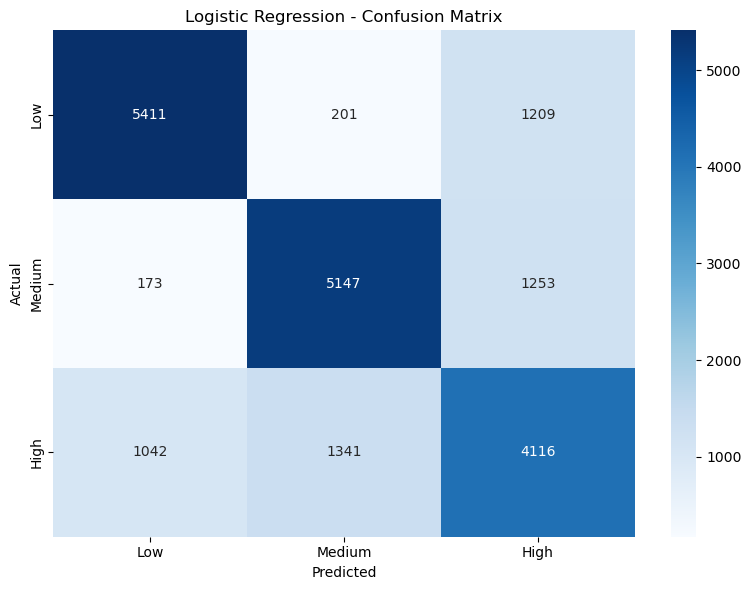

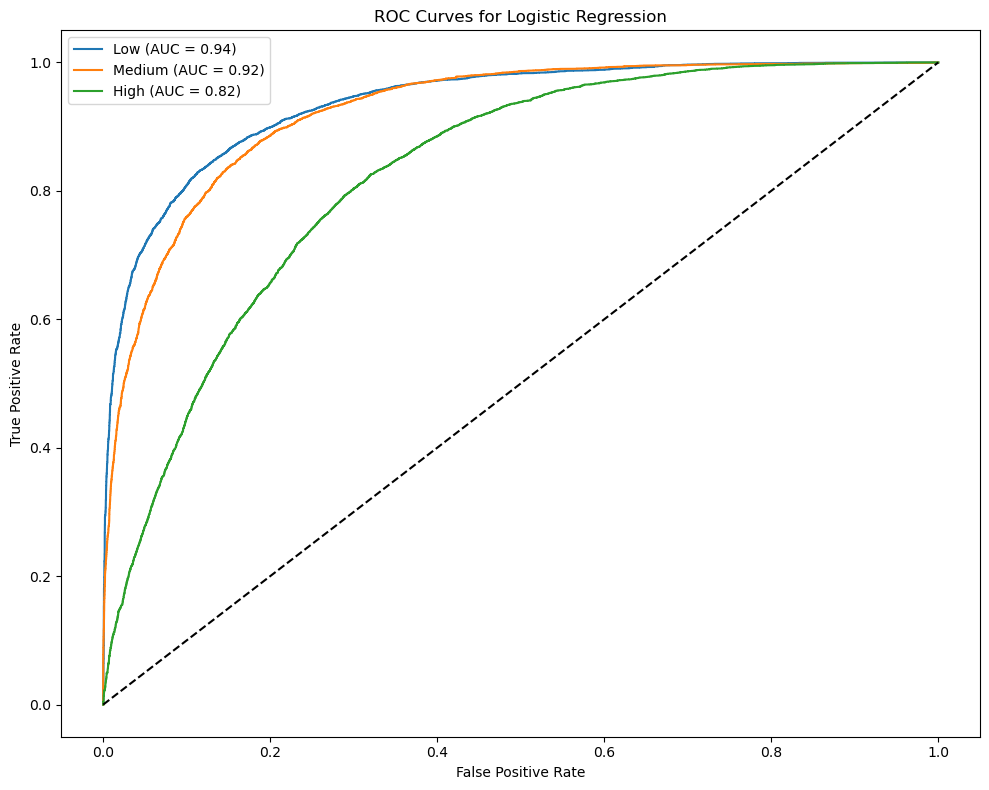

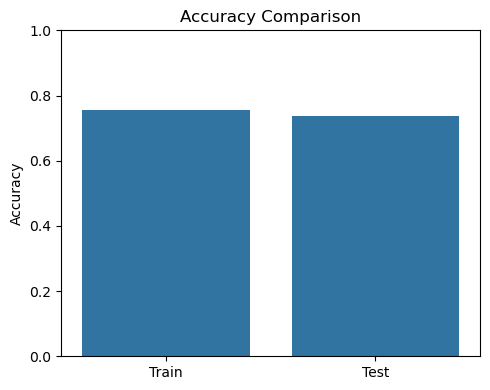

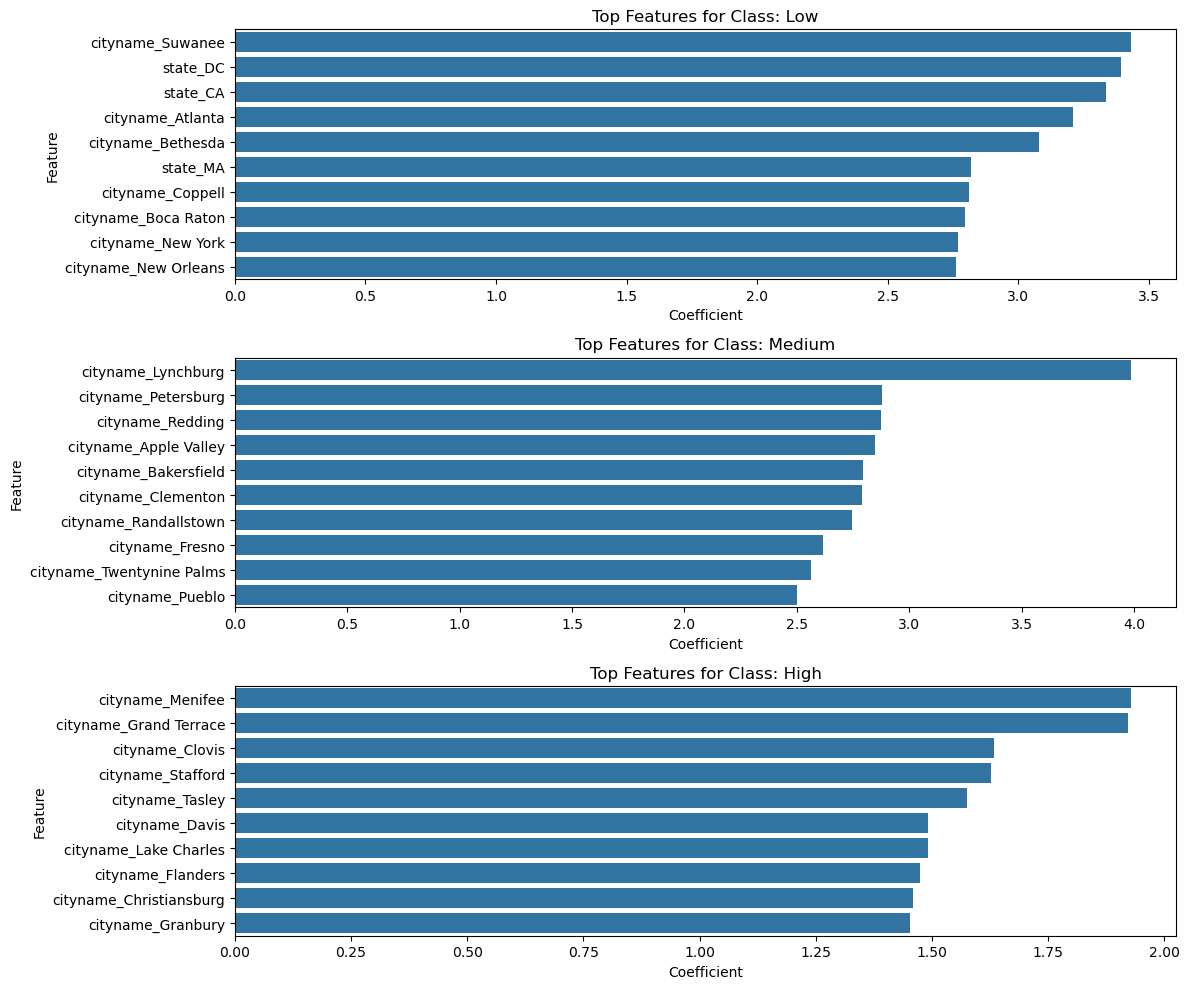

2025-04-22 20:59:59,623 - INFO - Model saved as logistic_regression_model.joblib


In [34]:

if __name__ == '__main__':
    df = load_data(file_path)
    X, y, features_num, features_cat, label_list = preprocess(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logger.info(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

    pipeline, preprocessor = build_pipeline(features_num, features_cat)
    logger.info("Training model...")
    pipeline.fit(X_train, y_train)

    logger.info("Evaluating model...")
    train_accuracy, test_accuracy = evaluate(pipeline, X_train, y_train, X_test, y_test, label_list)
    plot_accuracy(train_accuracy, test_accuracy)
    feature_importance(pipeline, preprocessor, X_train, label_list, features_num, features_cat)

    dump(pipeline, "logistic_regression_model.joblib")
    logger.info("Model saved as logistic_regression_model.joblib")
